In [2]:
%load_ext autoreload
%matplotlib inline
import pandas as pd
import numpy as np
from atpy import bellhop
import matplotlib.pyplot as plt

In [3]:
loadName = '/Users/edwardlrichards/cir_processing/Enviornment/processedData/soundSpeedProfile.pic'
filesDir = '/Users/edwardlrichards/cir_processing/bellhopFiles/'
ctdData = pd.read_pickle(loadName)
runType = 'C'

In [4]:
profile = ctdData.iloc[:,2]
zProfile = ctdData.index[np.bitwise_not(np.isnan(profile))]
profile = profile[np.bitwise_not(np.isnan(profile))]

profile = np.interp(ctdData.index, zProfile, profile)
# Guess the full profile is too much for some bellhop runs
decimation = 10
decZ = np.array(ctdData.index)[::decimation]
decSS = profile[::decimation]

In [5]:
saveName = 'test'
bellFile = bellhop.writeBellhop(decZ, decSS, runType,\
            saveDir=filesDir, name=saveName, numRGrid=500, numZGrid=200,\
            receiveRange=7)

In [6]:
bellhop.runBellhop(bellFile)

In [7]:
with open(bellFile+'.shd') as f:
    numRec = np.fromfile(f,dtype=np.int32, count=1)[0]
    f.seek(2 * 4 * numRec, 0)
    
    freq = np.fromfile(f, dtype=np.float32, count=1)[0]
    nTheta = np.fromfile(f, dtype=np.int32, count=1)[0]
    nsd = np.fromfile(f, dtype=np.int32, count=1)[0]
    nrd = np.fromfile(f, dtype=np.int32, count=1)[0]
    nrr = np.fromfile(f, dtype=np.int32, count=1)[0]
    attn = np.fromfile(f, dtype=np.float32, count=1)[0]
    
    f.seek(3 * 4 * numRec, 0)
    theta = np.fromfile(f, dtype=np.float32, count=nTheta)
    
    f.seek(4 * 4 * numRec, 0)
    sd = np.fromfile(f, dtype=np.float32, count=nsd)
    
    f.seek(5 * 4 * numRec, 0)
    rd = np.fromfile(f, dtype=np.float32, count=nrd)
    
    f.seek(6 * 4 * numRec, 0)
    rr = np.fromfile(f, dtype=np.float32, count=nrr)
    
    pressure = []
    for i in range(nrd):
        recnum = 7 + i
        f.seek(recnum * 4 * numRec, 0)
        temp = np.fromfile(f, dtype=np.float32, count = 2 * nrr)
        pressure.append(temp[0::2] + 1j * temp[1::2])
    pressure = np.array(pressure)

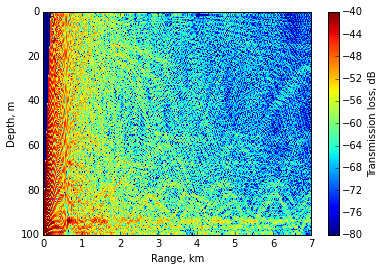

In [11]:
Z, R = np.meshgrid(rd, rr/1e3)
_ = plt.pcolormesh(R, Z, 20 * np.log10(np.abs(pressure) + np.spacing(1)).T)
_ = plt.clim(-80,-40)
cb = plt.colorbar()
_ = cb.set_label('Transmission loss, dB')
_ = plt.ylim(100, 0)
plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')